In [1]:
import pandas as pd
import numpy as np
import pyodbc  
from datetime import datetime 
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import seaborn as sns
import collections
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller # stationary or not 
from statsmodels.stats.diagnostic import acorr_ljungbox # white noise test
from statsmodels.tsa.stattools import arma_order_select_ic # AIC BIC
import statsmodels.api as sm # predict
from scipy import  stats
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data from data warehouse
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=htian;PWD=HeLeNtIAn52!")
cursor = conn.cursor()

# Run

## Core function (after running all other functions):

In [50]:
def time_series(DF, begin, cut, end, MasterSKU,  model, corr_result):
    data = data_clean(DF, begin, end, to_csv=True)

    print (model + ' model result with overall segment method: ')
    print (modeling(data,  MasterSKU, 'Overall', model ,cut ))

    print (model + ' model result with ProductCategory segment method: ')
    print (modeling(data,  MasterSKU, 'ProductCategory', model ,cut ))

    print (model + ' model result without segment: ')
    print (modeling(data,  MasterSKU, 'No_segment', model ,cut ))

In [51]:
begin = pd.to_datetime('2014-01-01')

In [52]:
end = pd.to_datetime('2018-05-31')

In [53]:
cut = pd.to_datetime('2017-05-31')

In [54]:
# for example: 

In [62]:
time_series(DF, begin, cut, end, 'Tundra 75',  'ARIMA', False)

The number of stable STD is: 1587
ARIMA model result with overall segment method: 
The ARIMA order value for class 0 is: ARIMA(8, 2, 0)
The ARIMA order value for class 1 is: ARIMA(0, 1, 1)
The ARIMA order value for class 2 is: ARIMA(8, 1, 2)
ARIMA Model result:  43.92 %
None
ARIMA model result with ProductCategory segment method: 
The ARIMA order value for class 0 is: ARIMA(9, 1, 3)
The ARIMA order value for class 1 is: ARIMA(0, 1, 1)
The ARIMA order value for class 2 is: ARIMA(8, 1, 2)
ARIMA Model result:  42.69 %
None
ARIMA model result without segment: 
The ARIMA order value for class 0 is: ARIMA(1, 1, 6)
ARIMA Model result:  47.06 %
None


In [56]:
# you can out put the detail information of time series model

In [ ]:
# for example the best ARIMA model for Tundra 75, class 0, without segment is ARIMA(1, 1, 6)

The number of stable STD is: 1587
QQ plot of residuals (should be like a straight line)
######################
result of residual's white noice testing (should be very large)
stat                  | p-value
[0.00075881] |
[0.97802391] |
######################
######################
mean squared error:  29.653755275357213
######################
Date
2017-05-29/2017-06-04      61.054918
2017-06-05/2017-06-11      28.419899
2017-06-12/2017-06-18      22.493218
2017-06-19/2017-06-25      27.981514
2017-06-26/2017-07-02      23.849612
2017-07-03/2017-07-09       7.164959
2017-07-10/2017-07-16      24.641508
2017-07-17/2017-07-23      13.738534
2017-07-24/2017-07-30      48.570533
2017-07-31/2017-08-06      12.485286
2017-08-07/2017-08-13      11.740544
2017-08-14/2017-08-20      25.768642
2017-08-21/2017-08-27      10.821096
2017-08-28/2017-09-03      15.562002
2017-09-04/2017-09-10      32.421326
2017-09-11/2017-09-17       0.992506
2017-09-18/2017-09-24      11.222770
2017-09-25/2017-10-0

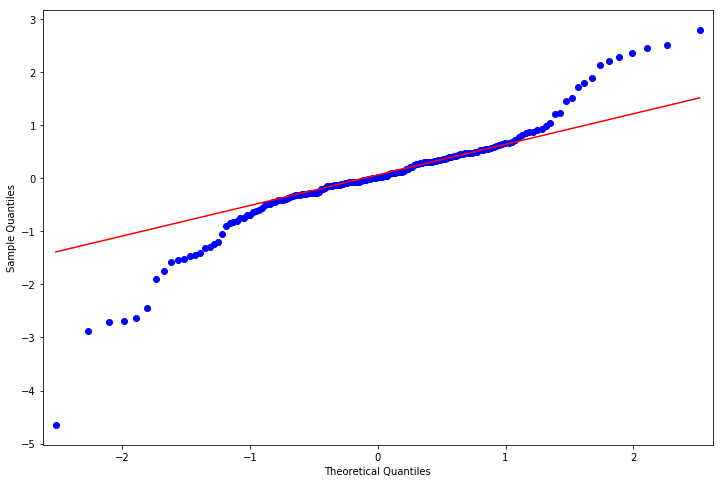

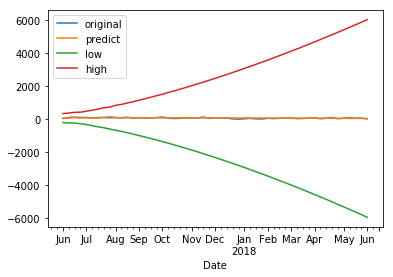

In [64]:
Plot('Tundra 75', 'ARIMA',(1, 1, 6), 'No_segment', DF,0, begin, end, cut)

In [ ]:
# you can do predict after getting the best Model result

In [ ]:
# for example, we already have the Tundra 75, Product category segment ARIMA result:
# ARIMA(9, 1, 3); ARIMA(0, 1, 1); ARIMA(8, 1, 2)
# Just combine all order value to the same list and take it to the prediction function
# do not forget to enter number of predictions you want 

In [68]:
Prediction('Tundra 75', 'ARIMA', [(9, 1, 3),(0, 1, 1),(8, 1, 2)], 'ProductCategory', DF, begin, end, cut, 5)

The number of stable STD is: 1587


[148.05929375222985,
 148.65695780603613,
 147.59882585711838,
 147.71019621266282,
 147.12504968267146]

## All other functions are below

# Data Pre-processing 

#### 1) read table; make sure all orderQty>0

In [3]:
DF = pd.read_sql("SELECT S.CustomerID, C.Customer, S.OrderDate, S.Requested_Date, S.SalesOffice, S.OrderQty, P.ProductCategory, P.MasterSKU,S.sourcesystem FROM EDW_DS.ORDERFCT S  inner join [EDW_DS].[PRODUCT_DIM] P ON P.ProductID = S.ProductID  left join EDW_DS.CUSTOMER_DIM C on S.CustomerID = C.CustomerID WHERE P.ISCORE = 'TRUE' and S.SalesOffice in ('STD','HYB')  and S.RejectionReason is null and S.Ordertype Not in ('ZARF','ZARM','ZEG2','ZERF','ZERM','ZRE') and S.SoldtoParty not in ('91860','0000107894','0000114883','0000108654') and S.OrderQty>0" , conn)

In [4]:
def Extend(data, MSKU1 ,MSKU2 , begin, end):
    Copy = data[(data.MasterSKU == MSKU1) & (data.Date >= begin) & (data.Date < end)]
    Copy['MasterSKU'] = MSKU2
    data1 = pd.concat([data, Copy])
    return data1

In [5]:
def Combine(data, MSKU_set, new_name):
    data.loc[data['MasterSKU'].isin(MSKU_set), 'MasterSKU'] = new_name
    return data

In [6]:
def stable_STD(data, begin, end):
    data = data.sort_values(by=["Date"])
    data = data[(data.Date>=begin) & (data.Date<=end)]   # select the data we want to analysis
    
    years = int((end-begin).days/365)   # how many years in this interval
    remainder = (end-begin).days%365   # if the last year is not complete, how long?
    new = begin + relativedelta(years=1)  
    STD1 = data[(data.Date>=begin)&(data.Date<new)].sort_values(by=["Date"]).drop_duplicates(subset=['CustomerID'])[['CustomerID']]
                                    # pick up all STD shown in 2014
    if remainder < 0.3:    
        years-=1
    for i in range(years):  # running a loop to select 2014 STD who also shown in each remaining year
        begin = new
        new = begin + relativedelta(years=1)
        Data = data[(data.Date>=begin)&(data.Date<new)]
        STD1 = pd.merge(STD1,Data,on='CustomerID').drop_duplicates(subset=['CustomerID'])[['CustomerID']]
    data = pd.merge(data, STD1, on = 'CustomerID')[['CustomerID', 'Date', 'SalesOffice', 'OrderQty', 'ProductCategory', 'MasterSKU']]
    return STD1, data # return the stable STD and their order history

In [7]:
def data_clean(DF, begin, end, to_csv=True):

    
    select= [ 'Tank 85',
 'Tundra 35',
 'Tundra 45',
 'R10 Lowball',
 'Tundra 105',
 'Tank 45',
 'Tundra 75',
 'Tundra 350',
 'Tundra 210',
 'Tundra 65',
 'Roadie 20',
 'R26 Bottle',
 'Flip 18',
 'Hopper 30',
 'R30 Tumbler',
 'Tundra 160',
 'Hopper2.0 30',
 'R18 Bottle',
 'Tundra 110',
 'R36 Bottle',
 'R20 Tumbler',
 'Flip 8',
 'R Colsters',
 'Flip 12',
 'Tundra 125',
 'Tundra 250']
    
    # only choose MasterSKU in 'select'
    DF=DF[DF['MasterSKU'].isin(select)]
    DF['OrderDate'] = pd.to_datetime(DF['OrderDate']) 
    DF=DF.fillna(pd.to_datetime('2010-01-01')) 
    DF['Requested_Date'] = pd.to_datetime(DF['Requested_Date'])  
    
    # 4% Requested_Date earlier than OrderDate
    Date = []
    for i in range(len(DF)):
        if DF.Requested_Date.iloc[i]==0:  # if the data is 0 (was 'nan' before)
            Date.append(DF.OrderDate.iloc[i])
        elif DF.OrderDate.iloc[i]>DF.Requested_Date.iloc[i]: # orderdate should be earlier than Requested_Date, these are 'strange' data
            Date.append(DF.OrderDate.iloc[i])
        else:
            Date.append(DF.Requested_Date.iloc[i])
    DF['Date']=Date
    
    DF1 = Extend(DF, 'Flip 12' , 'Flip 8' , '2016-08-01', '2017-07-01')
    
    DF2 = Extend(DF1, 'Flip 12' , 'Flip 18' , '2016-08-01', '2017-07-01') 
    
    DF3 = Extend(DF2, 'R18 Bottle' , 'R26 Bottle' , '2016-03-01', '2017-05-01')
    
    Large_Tundra = ['Tundra 160',
    'Tundra 125',
    'Tundra 110',
    'Tundra 250',
    'Tundra 105',
    'Tundra 350',
    'Tundra 210']
    
    DF4 = Combine(DF3, Large_Tundra, 'Large_Tundra')
    
    Hopper_30 = ['Hopper2.0 30', 'Hopper 30']
    
    DF5 = Combine(DF4, Hopper_30, 'Hopper 30')
    
    Tank = ['Tank 45', 'Tank 85']
    
    DF6 = Combine(DF5, Tank, 'Tank')
    
    result = stable_STD(DF6, begin, end)
    
    Stable_STD = result[0] 
    
    print('The number of stable STD is: ' + str(len(Stable_STD)))
    
    if to_csv:
        Stable_STD.to_csv('Stable_STD.csv')
    
    return result[1]

# Segment 

In [8]:
def remove_duplicates(lst):
        return list(collections.OrderedDict(zip(lst, lst)).values())

In [9]:
# after k-means clustering, the class name is not ordered by number size.(Class L=2, M=1, S=0)To change it, we use this function.
def ChangeLabel(res):
    df=res[0]
    cla=res[1]
    num = []
    n=len(cla)-1
    for item in cla:
        num.append(len(df[df.Class==item]))
    for i in range(len(num)):
        if i !=0:
            num[i]+=num[i-1]
    for i in range(len(num)):
        if i == 0:
            df.Class[:num[i]]=[n]*len(df.Class[:num[i]])
            
        else:
            df.Class[num[i-1]:num[i]] = [n]*len(df.Class[num[i-1]:num[i]])
        n-=1
    return df

In [10]:
def Overall_Segment(DF, cut):
    
    # calculate age of each STD
    
    age = DF[['CustomerID','Date']].sort_values(by=["Date"])
    age = age.drop_duplicates(subset='CustomerID')
    age2=age.copy()
    o=[str(x.year)+'-'+str(x.month) for x in age2.Date]
    age2.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    end = pd.to_datetime([cut]*len(age))           # we only can use the information in training data
    age2['end']=end
    live = ((age2.end-age2.Date) / np.timedelta64(1, 'M')).astype(int)
    age2['age']=live+1
    
    # use Overall quantity divided by age to get average order quantity
    
    Qty=DF['OrderQty'].groupby(DF['CustomerID']).sum().to_frame(name='overall_Qty').reset_index()
    Qty = Qty.merge(age2[['CustomerID','age']],left_on='CustomerID', right_on='CustomerID',how='inner')
    Qty['avg_Qty'] = Qty['overall_Qty']/Qty['age']
    Qty = Qty.sort_values(by=["avg_Qty"],ascending=False)

    # K means clustering:
    # 1) cluster STD into 2 groups
    # 2) redo cluster in the large group 
    
    X = np.array(Qty.avg_Qty.iloc[1:].reshape(-1,1))
    kmeans = KMeans(n_clusters = 2, random_state=0).fit(X)
    kmeans.labels_
    Class=[]
    Class.append(kmeans.labels_[0])
    Class+=list(kmeans.labels_)
    Qty["Class"] = Class
    ChangeLabel([Qty,remove_duplicates(kmeans.labels_)])
    L=len(Qty[Qty.Class==1])
    X1 = np.array(Qty.avg_Qty[L:].reshape(-1,1))
    kmeans1 = KMeans(n_clusters = 2, random_state=0).fit(X1)
    kmeans1.labels_
    M=len(kmeans1.labels_[kmeans1.labels_==1])
    Qty.Class[L:L+M]=2
    ChangeLabel([Qty,[1,2,0]])      # if number of cluster changed, this part must be changed
    data1 = pd.merge(DF, Qty[['CustomerID','Class']], on = 'CustomerID', how='left')
    return data1
       

In [11]:
def PC_Segment(DF,PC,cut):
    HC=DF[DF['ProductCategory']==PC]
    age = HC[['CustomerID','Date']].sort_values(by=["Date"])
    age = age.drop_duplicates(subset='CustomerID')
    age2=age.copy()
    o=[str(x.year)+'-'+str(x.month) for x in age2.Date]
    age2.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    end = pd.to_datetime([cut]*len(age))
    age2['end']=end
    live = ((age2.end-age2.Date) / np.timedelta64(1, 'M')).astype(int)
    age2['age']=live+1
    Qty=HC.groupby(['CustomerID'])['OrderQty'].sum().to_frame(name='overall_Qty').reset_index()
    Qty = Qty.merge(age2[['CustomerID','age']],left_on='CustomerID', right_on='CustomerID',how='inner')
    Qty['avg_Qty'] = Qty['overall_Qty']/Qty['age']
    Qty = Qty.sort_values(by=["avg_Qty"],ascending=False)
    X = np.array(Qty.avg_Qty.iloc[1:].reshape(-1,1))
    kmeans = KMeans(n_clusters = 2, random_state=0).fit(X)
    kmeans.labels_
    Class=[]
    Class.append(kmeans.labels_[0])
    Class+=list(kmeans.labels_)
    Qty["Class"] = Class
    ChangeLabel([Qty,remove_duplicates(kmeans.labels_)])
    L=len(Qty[Qty.Class==1])
    X1 = np.array(Qty.avg_Qty[L:].reshape(-1,1))
    kmeans1 = KMeans(n_clusters = 2, random_state=0).fit(X1)
    kmeans1.labels_
    M=len(kmeans1.labels_[kmeans1.labels_==1])
    Qty.Class[L:L+M]=2
    ChangeLabel([Qty,[1,2,0]])
    data1 = pd.merge(DF, Qty[['CustomerID','Class']], on = 'CustomerID', how='left')
    return data1

In [12]:
def corr_overallQty(dat):
    
    o=[str(x.year)+'-'+str(x.month) for x in dat.Date]
    dat.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    
    dfO1 = dat.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'OrderQty').reset_index()
    print ('Correlation between overall quantity and class size: ')
    print(dfO1.corr())
    print()
    
    dfD = dat[dat.ProductCategory=='Drinkware']
    dfD1 = dfD.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'DW_Qty').reset_index()
    print ('Correlation between Drinkware order quantity and class size: ')
    print(dfD1.corr())
    print()
    
    dfH = dat[dat.ProductCategory=='Hard Cooler']
    dfH1 = dfH.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'HC_Qty').reset_index()
    print ('Correlation between Hard Cooler order quantity and class size: ')
    print(dfH1.corr())
    print()
    
    dfS = dat[dat.ProductCategory=='Soft Cooler']
    dfS1 = dfS.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'SC_Qty').reset_index()
    print ('Correlation between Soft Cooler order quantity and class size: ')
    print(dfS1.corr())
    

In [13]:
# only for drinkware segment result check

In [13]:
def corr_drinkware(dat):
    
    o=[str(x.year)+'-'+str(x.month) for x in dat.Date]
    dat.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    
    dfD = dat[dat.ProductCategory=='Drinkware']
    dfD1 = dfD.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'DW_Qty').reset_index()
    print ('Correlation between Drinkware order quantity and class size: ')
    print(dfD1.corr())


In [14]:
# only for Hard Cooler segment result check

In [15]:
def corr_hardcooler(dat):
    
    o=[str(x.year)+'-'+str(x.month) for x in dat.Date]
    dat.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    
    dfH = dat[dat.ProductCategory=='Hard Cooler']
    dfH1 = dfH.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'HC_Qty').reset_index()
    print ('Correlation between Hard Cooler order quantity and class size: ')
    print(dfH1.corr())


In [16]:
# only for Soft Cooler segment result check

In [17]:
def corr_softcooler(dat):
    
    o=[str(x.year)+'-'+str(x.month) for x in dat.Date]
    dat.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    
    dfS = dat[dat.ProductCategory=='Soft Cooler']
    dfS1 = dfS.groupby(['Class','Date'])['OrderQty'].mean().to_frame(name = 'SC_Qty').reset_index()
    print ('Correlation between Soft Cooler order quantity and class size: ')
    print(dfS1.corr())

In [18]:
def segment(DF,cut,method, corr_result=True):
    if method == 'Overall':
        result = Overall_Segment(DF,cut)
        if corr_result:
            print (corr_overallQty(result))
        
    elif method == 'ProductCategory':
        result = (PC_Segment(DF,'Hard Cooler',cut),PC_Segment(DF,'Soft Cooler',cut),PC_Segment(DF,'Drinkware',cut))
        if corr_result:
            print (corr_hardcooler(result[0]))
            print (corr_softcooler(result[1])) 
            print (corr_drinkware(result[2]))
    else:             # No segment
        DF1=DF.copy()
        DF1['Class']=0
        result = DF1
    return result

# Time series 

In [21]:
# transfer datetime to month by change the date to the first day if that month. E.g '2017-03-XX' to '2017-03-01'

def day2month(data):
    data.copy()
    o=[str(x.year)+'-'+str(x.month) for x in data.Date]
    data.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    return data

In [22]:
# select specific MasterSKU

def select_Monthly(data, cut, MasterSKU, Class):
    data1 = data[(data.MasterSKU==MasterSKU)&(data.Class==Class)]
    df = day2month(data1[(data1.Date<=cut)])
    dft = day2month(data1[(data1.Date>cut)])
    
    DW1=df.groupby('Date')['OrderQty'].sum()
    DW1=DW1.to_frame(name = 'DW').reset_index()
    DW1=DW1.set_index(DW1.Date)
    dw=DW1['DW'].astype(float)
    
    DWT=dft.groupby('Date')['OrderQty'].sum()
    DWT=DWT.to_frame(name = 'DW').reset_index()
    DWT=DWT.set_index(DWT.Date)
    dwt=DWT['DW'].astype(float)
    
    return (dw,dwt)

In [23]:
def select_Weekly(data, Begin, cut, MasterSKU, Class):
    data1 = data[(data.Date>=Begin)&(data.MasterSKU==MasterSKU)&(data.Class==Class)]
    df = data1[(data1.Date<=cut)]
    dft = data1[(data1.Date>cut)]
    
    DW1=df[['Date','OrderQty']].reset_index().set_index(df.Date).OrderQty.astype(float).to_period('W')
    DW2=DW1.to_frame(name = 'OrderQty')
    DW2=DW2.groupby('Date')['OrderQty'].sum().to_frame(name = 'OrderQty').reset_index()
    DW2=DW2.set_index(DW2.Date)
    dw=DW2['OrderQty'].astype(float)
    
    DWT1=dft[['Date','OrderQty']].reset_index().set_index(dft.Date).OrderQty.astype(float).to_period('W')
    DWT2=DWT1.to_frame(name = 'OrderQty')
    DWT2=DWT2.groupby('Date')['OrderQty'].sum().to_frame(name = 'OrderQty').reset_index()
    DWT2=DWT2.set_index(DWT2.Date)
    dwt=DWT2['OrderQty'].astype(float)
    
    return (dw,dwt)

### b) Data check and fill nan 

In [24]:
def fill0(data,time):
    for date in time:
        if date not in data.index.values:
            data.loc[date] = 0
    data = data.sort_index()
    return data

In [25]:
# check missing data in time series, if yes, using 0 to fill

def check_Monthly(data,result,cut):
    TRA=select_Monthly(data, cut, 'Roadie 20', 0)[0].index.values  
    TES=select_Monthly(data, cut, 'Roadie 20', 0)[1].index.values # use Roadie 20 as Reference 
                                                          # because Roadie 20 have enough data (no missing value)
    if len(result[0])<len(TRA):
        R1=fill0(result[0],TRA)
    else:
        R1=result[0]
    if len(result[1])<len(TES):
        R2=fill0(result[1],TES)
    else:
        R2=result[1]
    return (R1,R2)

In [26]:
# Most masterSKU in each class do not have order every week, we need to fill the order quantity with 0 in these week

In [27]:
# check missing data in time series, if yes, using 0 to fill

def check_Weekly(data, result, begin, cut):
    TRA=select_Weekly(data, begin, cut, 'Roadie 20', 0)[0].index.values  
    TES=select_Weekly(data, begin, cut, 'Roadie 20', 0)[1].index.values # use Roadie 20 as Reference 
                                                          # because Roadie 20 have enough data (no missing value)
    if len(result[0])<len(TRA):
        R1=fill0(result[0],TRA)
    else:
        R1=result[0]
    if len(result[1])<len(TES):
        R2=fill0(result[1],TES)
    else:
        R2=result[1]
    return (R1,R2)

#### Order value select (there are 3 order values in ARIMA: p,d,q) 

In [28]:
# We can not only the function above to determine which order value to use. We also need to test all combination of order value.

In [29]:
def arima(maxorder,diff, data,test): # diff is a list contains all possible diff
    p = q = range(0, maxorder) 
    d = diff
    pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
    res=pd.DataFrame(columns=['Param','Smape','mse','AIC','BIC'])
    
    for param in pdq:
        try:
            mod = ARIMA(data.values,param)                                 
            results = mod.fit()
                
            
            # predict and add test to compare
            predicts = results.forecast(steps=len(test))[0]
            
            rms = sqrt(mean_squared_error(test, predicts))
            
            comp = pd.DataFrame()
            comp['original'] = test
            comp['predict'] = predicts
            q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
            Smape=np.mean(abs(q1))
            
            res=res.append({'Param':param,'Smape':Smape, 'mse':rms,'AIC':results.aic,'BIC':results.bic}, ignore_index=True)
          #  print (param,results.aic,results.bic,rms)
        except:
            continue
    res0 = res.sort_values(by=['Smape']).reset_index()['Smape'][0]        
    res1 = res.sort_values(by=["mse"]).reset_index()['Smape'][0]
    para0 = res.sort_values(by=['Smape']).reset_index()['Param'][0]  
    para1 = res.sort_values(by=['mse']).reset_index()['Param'][0]
    return (res0,res1,para0,para1)

#### Output the best result from ARIMA 

In [30]:
def ARIMA_modeling(data,order,test): 
    tempModel = ARIMA(data.values,order).fit() # fit the value into model
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    print("QQ plot of residuals (should be like a straight line)")
    fig = qqplot(tempModel.resid, line='q', ax=ax, fit=True)
    print("######################")
    noiseRes = acorr_ljungbox(tempModel.resid, lags=1)
    print ("result of residual's white noice testing (should be very large)")
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
    print("######################")
    predicts = tempModel.forecast(steps=len(test))[0]
    pred_CI = tempModel.forecast(steps=len(test))[2]
    low,high = [],[]
    for i in range(len(pred_CI)):
        low.append(pred_CI[i][0])
        high.append(pred_CI[i][1])
        
        
    comp = pd.DataFrame()
    comp['original'] = test
    comp['predict'] = predicts
    comp['low'] = low
    comp['high'] = high
    comp.plot()
    
    print("######################")
    rms = sqrt(mean_squared_error(test, predicts))
    print('mean squared error: ', rms)
    print("######################")
    
#    comp = comp[comp.original!=0]
    q=(abs(comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average MAPE: ',np.mean(abs(q)), '%')
    print('If MAPE is "Inf", it because the test data contains 0')
    print("######################")
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    print(q1)
    print('average Symmetric MAPE: ',np.mean(abs(q1)), '%')

### e) Seasonal ARIMA

#### Order value select (there are 7 order values in SARIMA: p,d,q, P,D,Q,S) 

In [31]:
def sarima(maxorder,diff,seasonal,data,test):
    p = q = range(0, maxorder) 
    d = diff
    pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
    

    res=pd.DataFrame(columns=['Param','Seasonal_param','Smape','mse','AIC','BIC'])
    
    for season in seasonal:
        pdq_x_PDQs = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
    
    
        for param in pdq:
            for seasonal_param in pdq_x_PDQs:
                try:
                    mod = sm.tsa.statespace.SARIMAX(data.values,
                                                    order=param,
                                                    seasonal_order=seasonal_param,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit()  
                
            
                   # predict and add test to compare
                    predicts = results.forecast(steps=len(test))
                    rms= sqrt(mean_squared_error(test, predicts))
          
                    comp = pd.DataFrame()
                    comp['original'] = test
                    comp['predict'] = predicts
                    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
                    Smape=np.mean(abs(q1))
        
                    res=res.append({'Param':param,'Seasonal_param':seasonal_param,'Smape':Smape, 'mse':rms,'AIC':results.aic,'BIC':results.bic}, ignore_index=True)
                    
                    
                except:
                    continue
    
    res0 = res.sort_values(by=['Smape']).reset_index()['Smape'][0]        
    res1 = res.sort_values(by=["mse"]).reset_index()['Smape'][0]
    paraA0 = res.sort_values(by=['Smape']).reset_index()['Param'][0] 
    paraA1 = res.sort_values(by=['Smape']).reset_index()['Seasonal_param'][0]
    paraS0 = res.sort_values(by=['mse']).reset_index()['Param'][0]
    paraS1 = res.sort_values(by=['mse']).reset_index()['Seasonal_param'][0]
    return (res0,res1,paraA0,paraA1,paraS0,paraS1)

#### Output the best result from SARIMA 

In [32]:
def SARIMA_modeling(data,order,seasonal_order,test): 
    mod = sm.tsa.statespace.SARIMAX(data.values, 
                                  #  exog=exog.values,
                                order=order, 
                                seasonal_order=seasonal_order,   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary())
    print("######################")
    pred = results.forecast(steps=len(test))
    comp = pd.DataFrame()
    comp['original'] = test
    comp['predict'] = pred
    comp.plot()
    print("######################")
    rms = sqrt(mean_squared_error(test, pred))
    print('mean squared error: ', rms)
    print("######################")
    noiseRes = acorr_ljungbox(results.resid, lags=1)
    print ("result of residual's white noice testing (should be very large)")
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
    print("######################")
    print('residuals')
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    print("######################")
    q=(abs(comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average MAPE: ',np.mean(abs(q)), '%')
    print('If MAPE is "Inf", it because the test data contains 0')
    print("######################")
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    print(q1)
    print('average Symmetric: ',np.mean(abs(q1)), '%')

### f) Baseline: Prophet & Naive Model

In [33]:
# output the predict result using Facebook package-Prophet

In [34]:
def prophet_W(train,test):
    X = pd.DataFrame(index=range(0,len(train)))
    c=[]
    for item in train.index:
        c.append(str(item).split('/')[0])
    X['ds'] = c
    X['y'] = train.values
    m = Prophet()
    m.fit(X)
    future_data = m.make_future_dataframe(periods=len(test), freq = 'w')
    forecast_data = m.predict(future_data)
    m.plot(forecast_data)
    predict=list(forecast_data['yhat'][-len(test):])
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = predict
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100

    return (np.mean(abs(q1)))

In [36]:
def prophet_M(train,test):
    X = pd.DataFrame(index=range(0,len(train)))
    X['ds'] = train.index
    X['y'] = train.values
    m = Prophet()
    m.fit(X)
    future_data = m.make_future_dataframe(periods=len(test), freq = 'm')
    forecast_data = m.predict(future_data)
    m.plot(forecast_data)
    predict=list(forecast_data['yhat'][-len(test):])
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = predict

    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    return (np.mean(abs(q1)))

In [38]:
# use the average of 12 training data as the first predict result then, use average of this predict result and 11 training 
# data as the second predict result 

In [39]:
def naive(train,test):
    data=list(train[-len(test):])
    r=[]
    for i in range(len(data)):
        r.append(np.mean(data[i:]+r))
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = r
    
    q1=(abs(comp['original']-comp['predict'])/((comp['original']+comp['predict'])/2))*100
    return (np.mean(abs(q1)))

# Run time series model

In [49]:
def modeling(data, MasterSKU, seg_method, model,cut ):
    aim=['Tundra 45', 'Tank', 'Roadie 20', 'Large_Tundra','Tundra 65','Tundra 35']
    Weekly = {'Tundra 75': '2014-03-01', 'Hopper 30':'2015-02-01', 'R30 Tumbler':'2014-04-01', 'R20 Tumbler':'2014-04-01', 
          'R Colsters': '2015-02-01', 'R10 Lowball':'2015-09-01', 'R36 Bottle':'2016-03-01','R18 Bottle':'2016-03-01',
          'R26 Bottle':'2016-03-01', 'Flip 18':'2016-08-01', 'Flip 8':'2016-08-01', 'Flip 12':'2016-08-01'}
    
    if seg_method == 'Overall':
        DATA = Overall_Segment(data, cut)
        n=3
    elif seg_method =='ProductCategory':
        item = data.drop_duplicates(['MasterSKU'])
        PC = item.ProductCategory[item.MasterSKU == MasterSKU].values[0] # find the productCategory this mastersku in 
        DATA = PC_Segment(data, PC, cut)
        n=3
    else:
        DATA = data.copy()
        DATA['Class']=0
        n=1
        
    Class0 = len(DATA[DATA.Class==0])
    Class1 = len(DATA[DATA.Class==1])
    Class2 = len(DATA[DATA.Class==2])
    
    
    smape = [0,0,0]
    if MasterSKU in aim:  # monthly
        
        for i in range(n):
            dat = check_Monthly(DATA,select_Monthly(DATA, cut, MasterSKU, i),cut)
            tra,tes = dat[0],dat[1]
            if model =='ARIMA':
                out = arima(10,[0,1,2], tra,tes)
                smape[i]=out[0]
                print ('The ARIMA order value for class '+ str(i) +' is: ARIMA' + str(out[2]))
            elif model == 'SARIMA':
                out = sarima(3, [0,1,2], range(0,13),tra,tes)
                smape[i]=out[0]
                print ('The SARIMA order value for class '+ str(i) +' is: SARIMA' + str(out[2])) +str(out[3])
            elif model == 'Prophet':
                out = prophet_M(tra, tes)
                smape[i]=out
            elif model == 'Naive':
                out = naive(tra,tes)
                smape[i]=out
        
    else:
        start = pd.to_datetime(Weekly[MasterSKU])
        
        for i in range(n):
            dat = check_Weekly(DATA, select_Weekly(DATA, start,cut, MasterSKU, i),start,cut)
            tra,tes = dat[0],dat[1]
            if model=='ARIMA':  # Model to use
                out = arima(10,[0,1,2], tra,tes)
                smape[i]=out[0]
                print ('The ARIMA order value for class '+ str(i) +' is: ARIMA' + str(out[2]))
            elif model == 'SARIMA':
                out = sarima(3, [0,1,2], range(0,13),tra,tes)
                smape[i]=out[0]
                print ('The SARIMA order value for class '+ str(i) +' is: SARIMA' + str(out[2])) +str(out[3])
            elif model == 'Prophet':
                out = prophet_W(tra, tes)
                smape[i]=out
            elif model == 'Naive':
                out = naive(tra,tes)
                smape[i]=out
            
    avg = (Class0*smape[0]+Class1*smape[1]+Class2*smape[2])/len(DATA)
    print (model +' Model result: ' , "%.2f" % avg, '%')    

# Plot output

In [61]:
def Plot(MasterSKU, model, order, seg_method, DF, Class, begin, end, cut):
    
    aim=['Tundra 45', 'Tank', 'Roadie 20', 'Large_Tundra','Tundra 65','Tundra 35']
    Weekly = {'Tundra 75': '2014-03-01', 'Hopper 30':'2015-02-01', 'R30 Tumbler':'2014-04-01', 'R20 Tumbler':'2014-04-01', 
          'R Colsters': '2015-02-01', 'R10 Lowball':'2015-09-01', 'R36 Bottle':'2016-03-01','R18 Bottle':'2016-03-01',
          'R26 Bottle':'2016-03-01', 'Flip 18':'2016-08-01', 'Flip 8':'2016-08-01', 'Flip 12':'2016-08-01'}
    
    data = data_clean(DF, begin, end, to_csv=True)
    if seg_method == 'Overall':
        DATA = Overall_Segment(data, cut)
        
    elif seg_method =='ProductCategory':
        item = data.drop_duplicates(['MasterSKU'])
        PC = item.ProductCategory[item.MasterSKU == MasterSKU].values[0] # find the productCategory this mastersku in 
        DATA = PC_Segment(data, PC, cut)
        
    else:
        DATA = data.copy()
        DATA['Class']=0
    
    if MasterSKU in aim:
        dat = check_Monthly(DATA,select_Monthly(DATA, cut, MasterSKU, Class),cut)
        tra,tes = dat[0],dat[1]
        if model=='ARIMA':
            print(ARIMA_modeling(tra,order,tes))
        elif model =='SARIMA':
            print(SARIMA_modeling(tra,order[0],order[1],tes))
            
    else:
        start = pd.to_datetime(Weekly[MasterSKU])
        dat = check_Weekly(DATA, select_Weekly(DATA, start,cut, MasterSKU, Class),start,cut)
        tra,tes = dat[0],dat[1]
        if model=='ARIMA':
            print(ARIMA_modeling(tra,order,tes))
        elif model =='SARIMA':
            print(SARIMA_modeling(tra,order[0],order[1],tes))
  

# Forecasting

In [65]:
def pred_ARIMA(tra,tes, order, predict_lenth):
    tempModel = ARIMA(tra.values,order).fit()
    predicts = tempModel.forecast(steps=predict_lenth+len(tes))[0]
    return list(predicts[len(tes):])

In [66]:
def pred_SARIMA(tra, tes, order,seasonal_order, predict_lenth):
    mod = sm.tsa.statespace.SARIMAX(tra.values, 
                                  #  exog=exog.values,
                                order=order, 
                                seasonal_order=seasonal_order,   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    pred = results.forecast(steps=predict_lenth+len(tes))
    return list(pred[len(tes):])

In [67]:
def Prediction(MasterSKU, model, order, seg_method, DF, begin, end, cut, predict_lenth):
    
    aim=['Tundra 45', 'Tank', 'Roadie 20', 'Large_Tundra','Tundra 65','Tundra 35']
    Weekly = {'Tundra 75': '2014-03-01', 'Hopper 30':'2015-02-01', 'R30 Tumbler':'2014-04-01', 'R20 Tumbler':'2014-04-01', 
          'R Colsters': '2015-02-01', 'R10 Lowball':'2015-09-01', 'R36 Bottle':'2016-03-01','R18 Bottle':'2016-03-01',
          'R26 Bottle':'2016-03-01', 'Flip 18':'2016-08-01', 'Flip 8':'2016-08-01', 'Flip 12':'2016-08-01'}
    
    data = data_clean(DF, begin, end, to_csv=True)
    
    result = [0]*predict_lenth
    
    if seg_method == 'Overall':
        DATA = Overall_Segment(data, cut)
        n=3
    elif seg_method =='ProductCategory':
        item = data.drop_duplicates(['MasterSKU'])
        PC = item.ProductCategory[item.MasterSKU == MasterSKU].values[0] # find the productCategory this mastersku in 
        DATA = PC_Segment(data, PC, cut)
        n=3
    else:
        DATA = data.copy()
        DATA['Class']=0
        n=1
        
    if MasterSKU in aim:
        for i in range(n):
            dat = check_Monthly(DATA,select_Monthly(DATA, cut, MasterSKU, i),cut)
            tra,tes = dat[0],dat[1]
            if model =='ARIMA':
                a = pred_ARIMA(tra,tes, order[i], predict_lenth)
                result = [a[i]+result[i] for i in range(len(a))]
            elif model == 'SARIMA':
                b = pred_SARIMA(tra, tes, order[i],seasonal_order[i], predict_lenth)
                result = [b[i]+result[i] for i in range(len(b))]
            
    else:
        start = pd.to_datetime(Weekly[MasterSKU])
        for i in range(n):
            dat = check_Weekly(DATA, select_Weekly(DATA, start,cut, MasterSKU, i),start,cut)
            tra,tes = dat[0],dat[1]
            if model=='ARIMA':
                a = pred_ARIMA(tra,tes, order[i], predict_lenth)
                result = [a[i]+result[i] for i in range(len(a))]
            elif model =='SARIMA':
                b = pred_SARIMA(tra, tes, order[i],seasonal_order[i], predict_lenth)
                result = [b[i]+result[i] for i in range(len(b))]
    return result